In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import collections

In [2]:
%matplotlib notebook

In [63]:
def interpolate(a=[], b=[], amt=0.5):
    """ Linear interpolation for each dimension i in a,b
    a,b: array-like or float
    """
    return (1-amt) * a + amt * b
    

class Iterator:
    # Generate species identifiers (index values/keys)
    def __init__(self, start=0):
        self._next = start
        
    def get_next(self):
        # Return next identifier value and update internal state
        self._next += 1
        return self._next - 1

# Bak-Sneppen class and Lattice class

In [67]:
class BS:
    def __init__(self, N, network, random_relations=False, species_ids=None, fitnesses=None):
        """ Bak-Sneppen Model
        g: graph of the co-evolution dependencies
        network: type of graph
        """
        self.network = network
        # create graph
        if network[0] == "watts-strogatz":
            (_, k, p) = network
            self.g = nx.watts_strogatz_graph(N, k, p)
            if species_ids is None:
                species_ids = range(N)
            if fitnesses is None:
                fitnesses = np.random.random(N)
            if random_relations:
                random_indices = np.random.permutation(N)
                species_ids = species_ids[random_indices]
                fitnesses = fitnesses[random_indices]
            for node in self.g:
                self[node]["id"] = species_ids[node]
                self[node]["fitness"] = fitnesses[node]

        else:
            raise ValueError("Unknown network type") 


    def update(self, node_id, new_species_id, fitness=None):
        if fitness is None:
            fitness = np.random.random()
        self[node_id]["fitness"] = fitness
        self[node_id]["id"] = new_species_id
            
    @property
    def N(self):
        return self.network.number_of_nodes
            
    def __getitem__(self, i):
        return self.g.node[i]
    
    @property
    def species(self):
        return self.g.nodes.data("id")
    
    def species_as_list(self):
#         return dict(self.g.nodes.data("id")).values()
        return [i for _,i in self.g.nodes.data("id")]
    
    def fitness(self):
        return self.g.nodes.data("fitness")
    
    def fitness_array(self):
        return np.array([f for _,f in self.fitness()])
    
    def min_fitness(self):
        return min(self.fitness(), key=lambda x: x[1])
    
    def max_fitness(self):
        return max(self.fitness(), key=lambda x: x[1])
    
    def sorted_fitness(self):
        return sorted(self.fitness(), key=lambda x: x[1])
    
    def contains(self, species_id) -> bool:
        return species_id in self.species_as_list()

In [73]:
class Lattice:
    def __init__(self, dimensions, N, network, P, fitness_correlation=1, migration_bias=1):
        """
        dimension: shape of lattice, e.g. N x N
        P: probability of mutation (Bernoulli trial)
            success -> mutation (replacement by new species)
            fail -> migration (replacement by a species originating from neighbourhood)
        fitness_correlation: float in [0,1]    
            Parameter that controls fitness after migration. 
            Low values maintain the previous fitness and high values randomize the fitness.
        migration_bias: float in [-1,1]
            Parameter to controll the influence of fitness on migration. Set to zero to disable the influence.
        """
        self.dimensions = dimensions
        self.P = P
        self.identifier_iter = Iterator(start=np.prod(dimensions) * N)
        self.fitness_correlation = fitness_correlation
        self.migration_bias = migration_bias
        # create lattice
        self.lattice = nx.grid_graph(list(dimensions), periodic=True)
        # create BS network in each point of the lattice
        for (i, point) in enumerate(self.lattice):
            self.lattice.node[point]["BS"] = BS(N, network, species_ids=range(N*i, N*(i+1)), fitnesses=None)


    def __getitem__(self, i):
        return self.lattice.node[i]["BS"]

    @property
    def N(self):
        return self.lattice.number_of_nodes
    
    def run(self, t_max: int, collect_data=False):
        if collect_data:
            self.data = np.empty((t_max+1,) + self.dimensions, dtype=object)
            for i,j in np.ndindex(self.dimensions):
                self.data[0, i, j] = set(self[i, j].species_as_list())
        
        for t in range(1, t_max+1):
            # Randomize update order to reduce iteration-order side effects
            for i, j in np.random.permutation(self.lattice):
                # select node with lowest fitness
                bs = self[i,j]
                lattice_neighbours = list(self.lattice[i,j])
                idx, _fitness = bs.min_fitness()
                node_indices = [idx] + list(bs.g[idx])
                # apply mutation-migration step for each node
                for node_id in node_indices:
                    if np.random.random() < self.P:
                        # mutate
                        bs.update(node_id, self.identifier_iter.get_next())
                    else:
                        # migrate
                        self.migrate(bs, node_id, lattice_neighbours)


                if collect_data:
                    self.data[t, i, j] = set(bs.species_as_list())


    def migrate(self, bs, node_id, lattice_neighbours=[]):
        # select a random neighbour as migration source
        bs_source = self[lattice_neighbours[np.random.randint(0, len(lattice_neighbours))]]
        source_nodes = bs_source.g
        if self.migration_bias > 0:
            # select source species with best (or worst) fitness
            # normalize fitness values to robust-ize the randomization process
            fitnesses =  bs_source.fitness_array()
            min_ = np.min(fitnesses)
            max_ = 1
            fitnesses_normalized = (fitnesses - min_) / (max_ - min_)
            probabilities = 1 - self.migration_bias * (1 - fitnesses_normalized)
            # transform to array to allow multi-selection
            source_nodes = np.array(source_nodes)
            source_nodes = source_nodes[probabilities > np.random.random(probabilities.size)]

        # use dummy dict to optimize lookup
        target_species_ids = {k[1]:None for k in bs.species}
        # iterate randomly over selection
        for source_node_id in np.random.permutation(source_nodes):
            species_id = bs_source[source_node_id]["id"]
            # let the species migrate from source to target bs
            if species_id not in target_species_ids:
                # migrate and stop searching
                fitness_new = interpolate(bs_source[source_node_id]["fitness"], 
                                          np.random.random(), 
                                          amt=self.fitness_correlation)
                bs.update(node_id, species_id, fitness=fitness_new)
                return

        print("Migration failed from {} to {}".format(bs_source.species(), bs.species()))

    def draw(self):
        nx.draw(self.lattice, with_labels=True)
    
    def mean_species(self):
        ids = set()
        for point in self.lattice:
            ids = ids.union(self[point].species_as_list())
        return len(ids) / np.prod(self.dimensions)

            
    def area_curve(self, sampling_scheme='quadrats', log=True):
        # sampling_scheme = ['nested'|'quadrats']
        fig, ax = plt.subplots()

        if sampling_scheme == 'nested':
            area_curve = np.empty((self.dimensions[0],2))
            for s in range(1, self.dimensions[0]+1):
                species = set()
                for i in range(0, s):
                    for j in range(0, s):
                        species = species.union(self[(i,j)].species_as_list())

                nr = len(species)
                area_curve[s-1] = (s**2, nr)
            print(area_curve)
            ax.plot(*area_curve.T, "o")
            
            power = (np.log10(area_curve[-1,1]) - np.log10(area_curve[0,1])) / (np.log10(self.dimensions[0]**2) - np.log10(1))


        elif sampling_scheme == 'quadrats':
            area_curve = collections.OrderedDict()
            sd = []
            for grain_size in range(1, max(self.dimensions)+1):
                assert self.dimensions[0] == self.dimensions[1]
                means = []
                i = 0
                for interval_i in range(0, self.dimensions[0]-grain_size+1):
                    for interval_j in range(0, self.dimensions[1]-grain_size+1):
                        species = set()
                        for i,j in np.ndindex((grain_size,grain_size)):
                            ii = interval_i + i
                            jj = interval_j + j
                            species = species.union(self[ii,jj].species_as_list())
                            i += 1

                        means.append(len(species))
                
                area_curve[grain_size**2] = np.mean(means)
                sd.append(np.std(means)*1.96/np.sqrt(i))
                print('grain size: %i, mean: %0.3f'% (grain_size, np.mean(means)))
            ax.errorbar(list(area_curve.keys()), list(area_curve.values()), yerr=sd, fmt="x", capsize=2)
            ax.plot()
            
            power = (np.log10(area_curve[self.dimensions[0]**2]) - np.log10(area_curve[1])) / (np.log10(self.dimensions[0]**2) - np.log10(1))

        
        ax.set_xlabel("Area")
        ax.set_ylabel("Number of species")
        
        if log:
            ax.set_xscale("log")
            ax.set_yscale("log")
            
        print("power: {}".format(power))

# Experiments

CPU times: user 4.09 s, sys: 30.4 ms, total: 4.12 s
Wall time: 4.22 s


<IPython.core.display.Javascript object>


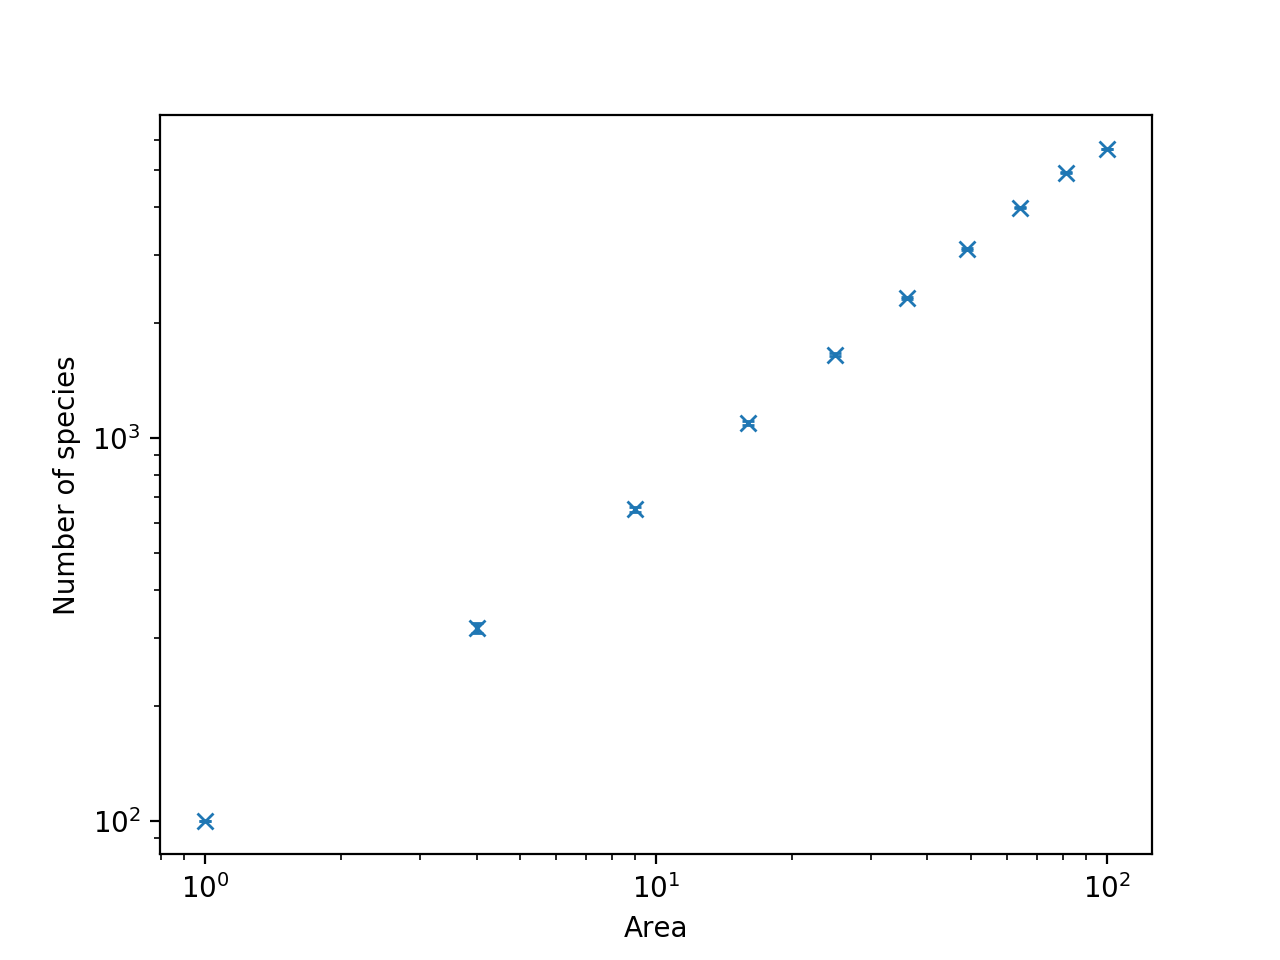

grain size: 1, mean: 100.000
grain size: 2, mean: 318.951
grain size: 3, mean: 649.938
grain size: 4, mean: 1093.327
grain size: 5, mean: 1650.000
grain size: 6, mean: 2322.840
grain size: 7, mean: 3107.250
grain size: 8, mean: 3989.667
grain size: 9, mean: 4923.000
grain size: 10, mean: 5684.000
power: 0.877327034627716


In [74]:
l = Lattice((10,10), 100, ("watts-strogatz", 3, 0), 1/3, 0.8)
%time l.run(100)

l.area_curve("quadrats")

## Mean number of species over time

<IPython.core.display.Javascript object>


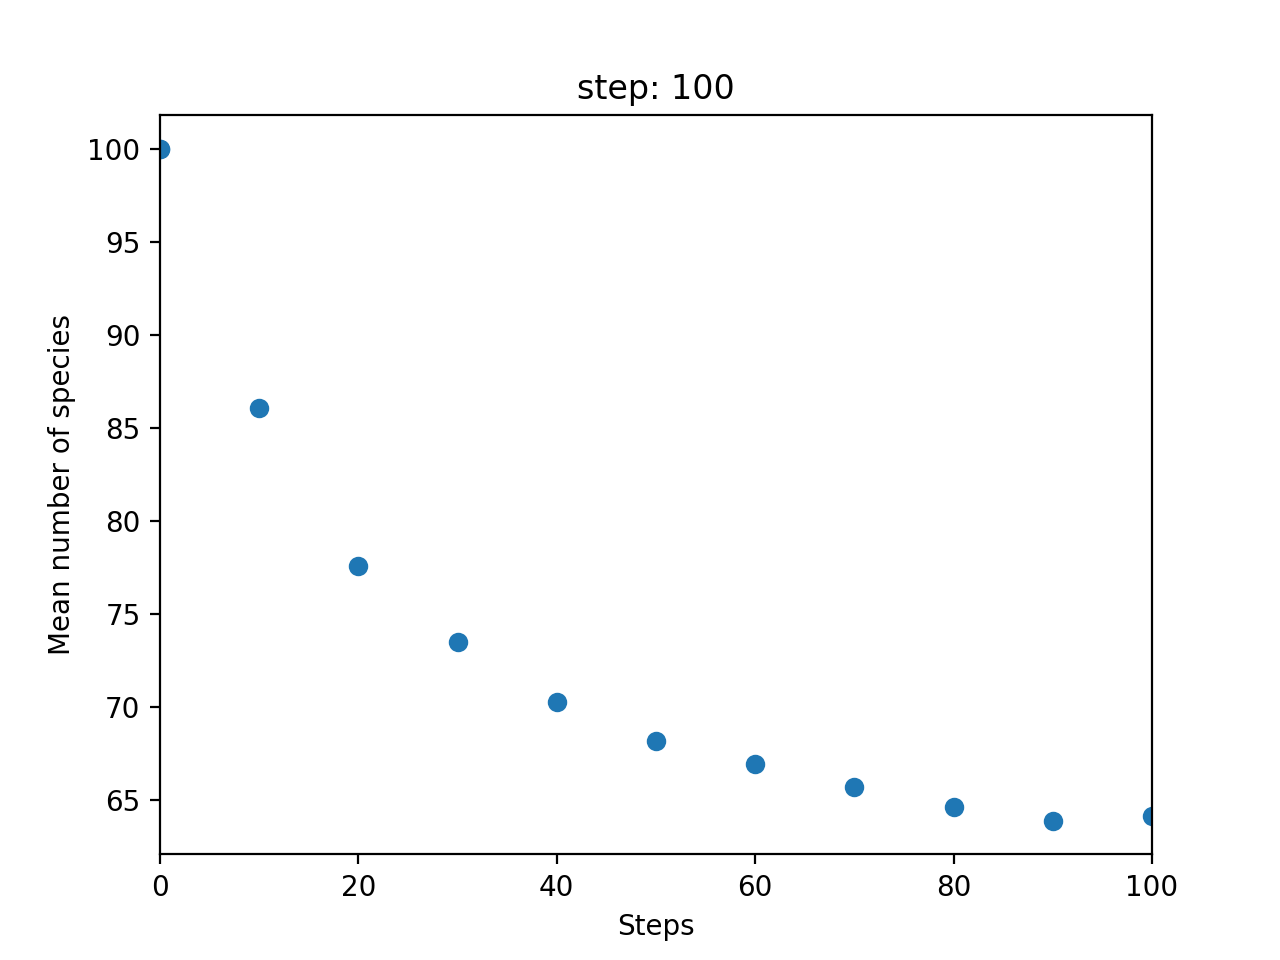

In [57]:
dimensions = (6,6)
l = Lattice(dimensions, 100, ("watts-strogatz", 3, 0), 1/3)
step_size = 10
steps = 10

fig, ax = plt.subplots()
line, = plt.plot([],[], "o")
ax.set_xlim(0, steps*step_size)
ax.set_xlabel("Steps")
ax.set_ylabel("Mean number of species")

def animate(i):
    if i > 0:
        l.run(step_size)

    t = i * step_size
    
    ax.set_title("step: {}".format(t))
    line.set_xdata(np.append(line.get_data()[0], [t]))
    line.set_ydata(np.append(line.get_data()[1], [l.mean_species()]))
    
    ax.relim()
    ax.autoscale_view()
    
    return line

ani = animation.FuncAnimation(fig, animate, np.arange(steps+1), interval=500, repeat=False, blit=True, save_count=1000)

## Area curve over time

<IPython.core.display.Javascript object>


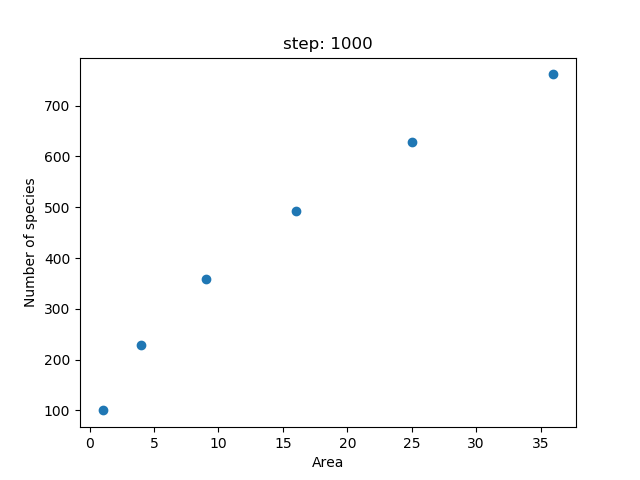

In [7]:
np.random.seed(0)

l = Lattice((10,10), 100, ("watts-strogatz", 3, 0), 1/3)
l.run(1000, collect_data=True)

fig, ax = plt.subplots()
line, = ax.plot([],[], "o")
ax.set_xlabel("Area")
ax.set_ylabel("Number of species")
# ax.set_xscale("log")
# ax.set_yscale("log")

step_size = 10

def animate(data):
    step, species = data
    
    ax.set_title("step: {}".format(step * step_size))

    # calculate area curve
    area_curve = collections.OrderedDict()
    for grain_size in range(1, max(dimensions)+1):
        means = []
        i = 0
        for interval_i in range(0, l.dimensions[0]-grain_size+1):
            for interval_j in range(0, l.dimensions[1]-grain_size+1):
                unique_species = set()
                for i,j in np.ndindex((grain_size,grain_size)):
                    ii = interval_i + i
                    jj = interval_j + j
                    unique_species = unique_species.union(species[ii,jj])
                    i += 1

                means.append(len(unique_species))

        area_curve[grain_size**2] = np.mean(means)
    line.set_xdata(list(area_curve.keys()))
    line.set_ydata(list(area_curve.values()))

    ax.relim()
    ax.autoscale_view()
    
    return line

ani = animation.FuncAnimation(fig, animate, enumerate(l.data[::step_size]), interval=100, repeat=False, blit=True, save_count=1000)

In [13]:
np.random.multinomial(1,[2/3,1/2])

array([1, 0])

In [14]:
2/3 + 1/2

1.1666666666666665